In this notebook, we examine with the variances of the gradient estimators described in bernoulli_optimization_experiments.py

In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn
import torch.optim as optim 

from copy import deepcopy

import bernoulli_experiments_lib as bern_lib

import sys
sys.path.insert(0, '../../rb_utils/')
import optimization_lib as optim_lib
import baselines_lib as bs_lib

In [3]:
softmax = nn.Softmax(dim = 0)

sigmoid = nn.Sigmoid()

In [4]:
np.random.seed(454)
_ = torch.manual_seed(454)

In [5]:
# fixed parameters
d = 3
# p0 = torch.rand(d)
p0 = torch.Tensor([0.6, 0.51, 0.48])
print('p0: ', p0, '\n')

print('sum(p0^2): ', torch.sum(p0**2))
print('sum((1 - p0)^2): ', torch.sum((1 - p0)**2), '\n')

# the optima
x_optimal = torch.argmin(torch.Tensor([torch.sum(p0**2), torch.sum((1 - p0)**2)]))

optimal_loss = torch.min(torch.Tensor([torch.sum(p0**2), torch.sum((1 - p0)**2)]))

print('optimal loss: ', optimal_loss)
print('optimal x: ', x_optimal.numpy())

p0:  tensor([ 0.6000,  0.5100,  0.4800]) 

sum(p0^2):  tensor(0.8505)
sum((1 - p0)^2):  tensor(0.6705) 

optimal loss:  tensor(0.6705)
optimal x:  1


In [6]:
# random init for phi
phi0 = torch.Tensor([0.0])
phi0.requires_grad_(True)
print('init phi0: ', phi0)
print('init e_b: ', sigmoid(phi0))

init phi0:  tensor([ 0.])
init e_b:  tensor([ 0.5000])


In [7]:
params = [phi0]
optimizer = optim.SGD(params, lr = 1.0)

# True gradient

In [8]:
bern_experiment = bern_lib.BernoulliExperiments(p0, d, phi0)

In [9]:
bern_experiment.set_var_params(deepcopy(phi0))

In [10]:
optimizer.zero_grad()

In [11]:
loss = bern_experiment.get_full_loss()

In [12]:
loss.backward()

In [13]:
true_grad = deepcopy(bern_experiment.var_params['phi'].grad)
print(true_grad)

tensor(1.00000e-02 *
       [-4.5000])


In [14]:
# analytically integrate REINFORCE gradient: should recover the true gradient

In [15]:
bern_experiment.set_var_params(deepcopy(phi0))
optimizer.zero_grad()
ps_loss = bern_experiment.get_pm_loss(topk = 8, grad_estimator = bs_lib.reinforce)

In [16]:
ps_loss.backward()
reinforce_analytic_grad = deepcopy(bern_experiment.var_params['phi'].grad)
print(reinforce_analytic_grad)

tensor(1.00000e-02 *
       [-4.5000])


In [17]:
assert reinforce_analytic_grad == true_grad

In [19]:
# Function to sample the gradient from a given estimator 

def sample_gradient(phi0, bern_experiment, topk, grad_estimator, n_samples = 10000):
    params = [phi0]
    optimizer = optim.SGD(params, lr = 1.0)

    grad_array = torch.zeros(n_samples)
    
    for i in range(n_samples): 
        bern_experiment.set_var_params(deepcopy(phi0))
        optimizer.zero_grad()
        ps_loss = bern_experiment.get_pm_loss(topk = topk, grad_estimator = grad_estimator)
        ps_loss.backward()
        
        grad_array[i] = bern_experiment.var_params['phi'].grad

    return grad_array

# Reinforce + CV gradient

In [24]:
n_samples = 10000
reinforce_grads = sample_gradient(phi0, bern_experiment, 
                                  topk = 0, 
                                  grad_estimator = bs_lib.reinforce_w_double_sample_baseline,
                                  n_samples = n_samples)

In [25]:
print('true_grad: ', true_grad.numpy())
print('mean reinforce grad: ', torch.mean(reinforce_grads).numpy())
print('variance: ', torch.var(reinforce_grads).numpy())

print('scaled error: ', (torch.std(reinforce_grads) / np.sqrt(n_samples) * 3).numpy())

true_grad:  [-0.04500001]
mean reinforce grad:  -0.045078
variance:  0.0127537735
scaled error:  0.0033879783


Text(0.5,0,'reinforce gradients')

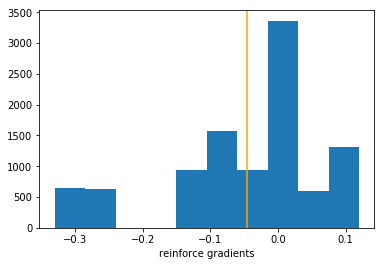

In [26]:
plt.hist(reinforce_grads)
plt.axvline(x=true_grad, color = 'orange') # true gradient 

plt.xlabel('reinforce gradients')

# Rao-Blackwellize

In [27]:
print(phi0)

tensor([ 0.])


In [28]:
n_samples = 10000

mixed_grads_array = torch.zeros((2**d + 1, n_samples))

for i in range(0, 2**d + 1): 
    print(phi0)
    grads = sample_gradient(phi0, bern_experiment, 
                                topk = i, 
                                grad_estimator = bs_lib.reinforce_w_double_sample_baseline,
                                n_samples = n_samples)
    
    mixed_grads_array[i, :] = grads
    
    print('topk = {}'.format(i))
    print('mean reinforce grad: ', torch.mean(grads).numpy())
    print('variance: ', torch.var(grads).numpy())


tensor([ 0.])
topk = 0
mean reinforce grad:  -0.046818
variance:  0.012764755
tensor([ 0.])
topk = 1
mean reinforce grad:  -0.043681122
variance:  0.007718648
tensor([ 0.])
topk = 2
mean reinforce grad:  -0.04451987
variance:  0.006297237
tensor([ 0.])
topk = 3
mean reinforce grad:  -0.04491262
variance:  0.005174288
tensor([ 0.])
topk = 4
mean reinforce grad:  -0.04502225
variance:  0.0036822422
tensor([ 0.])
topk = 5
mean reinforce grad:  -0.045825124
variance:  0.0015894222
tensor([ 0.])
topk = 6
mean reinforce grad:  -0.044402372
variance:  0.0011764194
tensor([ 0.])
topk = 7
mean reinforce grad:  -0.0447125
variance:  0.000987462
tensor([ 0.])
topk = 8
mean reinforce grad:  -0.044758122
variance:  0.0009925012


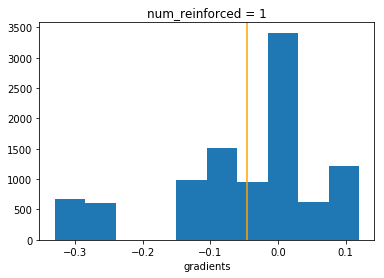

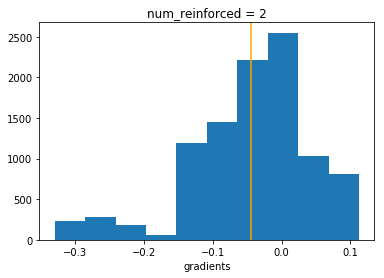

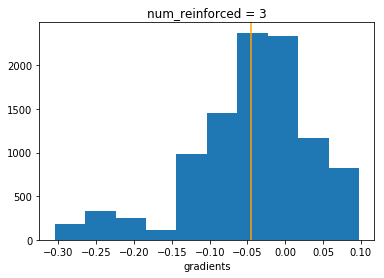

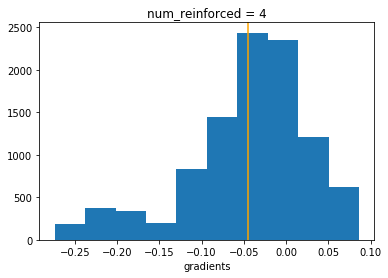

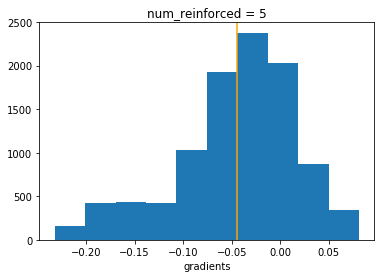

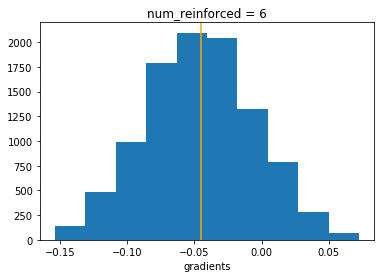

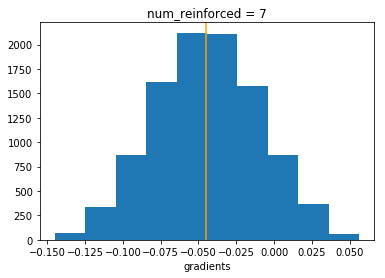

In [29]:
# Lets look at the histogram of the distribution of 
# the gradient estimates

for i in range(1, 2**d): 
    plt.figure()
    plt.hist(mixed_grads_array[i-1, :])
    plt.axvline(x=true_grad, color = 'orange') # true gradient 
    
    plt.title('num_reinforced = {}'.format(i))
    plt.xlabel('gradients')

In [30]:
fontsize = 16

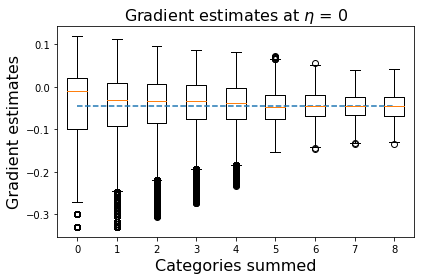

In [31]:
# summarize distribution all on the same plot
# Error bars are 3 * st. error of the distribution 

mixed_grads_means = np.mean(mixed_grads_array.numpy(), axis = 1)
mixed_grads_stds = np.std(mixed_grads_array.numpy(), axis = 1)

# plt.errorbar(np.arange(0, 2**d + 1), 
#              mixed_grads_means,
#              yerr= mixed_grads_stds * 3 / np.sqrt(n_samples))

plt.boxplot(mixed_grads_array, positions = range(2**d + 1))

plt.plot(np.linspace(0, 2**d), true_grad.numpy() * np.ones(50), '--')

plt.ylabel('Gradient estimates', fontsize = fontsize)
plt.xlabel('Categories summed', fontsize = fontsize)
plt.title('Gradient estimates at $\eta$ = {}'.format(0), fontsize = fontsize)

plt.tight_layout()


Text(0.5,1,'standard errors at $\\eta$ = 0.0')

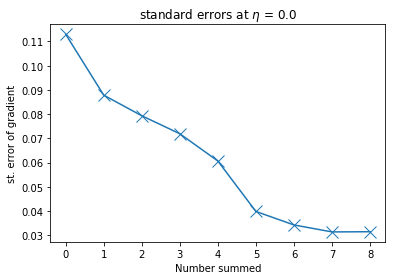

In [32]:
plt.plot(np.arange(0, 2**d + 1), mixed_grads_stds, 'x-', markersize = 12)
plt.xlabel('Number summed')
plt.ylabel('st. error of gradient')
plt.xlabel('Number summed')
plt.ylabel('st. error of gradient')
plt.title('standard errors at $\eta$ = {}'.format(phi0.detach().numpy()[0]))

In [33]:
# The effect of Rao-Blackwellization is better as the variational distribution becomes more concentrated

In [34]:
phi0 = torch.Tensor([-4.0])
phi0.requires_grad_(True)

tensor([-4.])

In [35]:
bern_experiment.set_var_params(deepcopy(phi0))
class_weights = torch.exp(bern_experiment.get_log_q())
print(class_weights)

tensor([[ 9.4701e-01,  1.7345e-02,  1.7345e-02,  3.1769e-04,  1.7345e-02,
          3.1769e-04,  3.1769e-04,  5.8186e-06]])


In [36]:
optimizer.zero_grad()
loss = bern_experiment.get_full_loss()
loss.backward()


true_grad = deepcopy(bern_experiment.var_params['phi'].grad)
print(true_grad)

tensor(1.00000e-03 *
       [-3.1793])


In [37]:
bern_experiment.set_var_params(deepcopy(phi0))
optimizer.zero_grad()
ps_loss = bern_experiment.get_pm_loss(topk = 8, grad_estimator = bs_lib.reinforce)

ps_loss.backward()
reinforce_analytic_grad = deepcopy(bern_experiment.var_params['phi'].grad)
print(reinforce_analytic_grad)

tensor(1.00000e-03 *
       [-3.1793])


In [38]:
assert reinforce_analytic_grad == true_grad

In [39]:
# re-examine the effect of rao-blackwellization

In [40]:
print(phi0)

tensor([-4.])


In [41]:
n_samples = 10000

mixed_grads_array2 = torch.zeros((2**d + 1, n_samples))

for i in range(0, 2**d + 1): 
    grads = sample_gradient(phi0, bern_experiment, 
                                  topk = i, 
                                grad_estimator = bs_lib.reinforce_w_double_sample_baseline,
                                  n_samples = n_samples)
    
    mixed_grads_array2[i, :] = grads
    
    print('topk = {}'.format(i))
    print('mean reinforce grad: ', torch.mean(grads).numpy())
    print('variance: ', torch.var(grads).numpy())


topk = 0
mean reinforce grad:  -0.003443763
variance:  0.0007946166
topk = 1
mean reinforce grad:  -0.0030879935
variance:  3.297406e-05
topk = 2
mean reinforce grad:  -0.0032096484
variance:  2.0923619e-05
topk = 3
mean reinforce grad:  -0.0032012502
variance:  4.664265e-06
topk = 4
mean reinforce grad:  -0.0031648788
variance:  2.424848e-06
topk = 5
mean reinforce grad:  -0.003207009
variance:  2.8407187e-06
topk = 6
mean reinforce grad:  -0.0032014824
variance:  2.570258e-06
topk = 7
mean reinforce grad:  -0.0031996889
variance:  2.543648e-06
topk = 8
mean reinforce grad:  -0.0031709066
variance:  2.5727218e-06


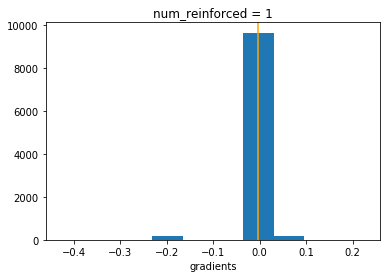

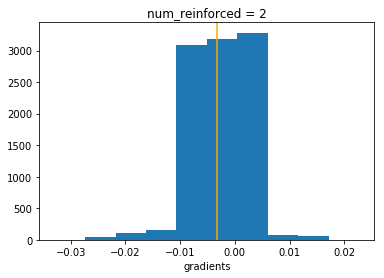

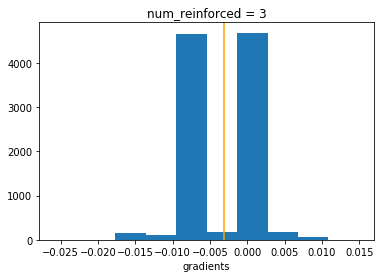

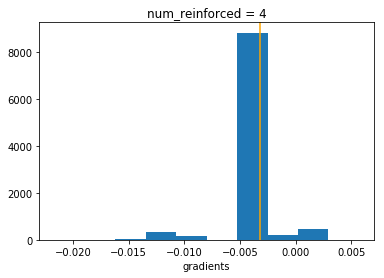

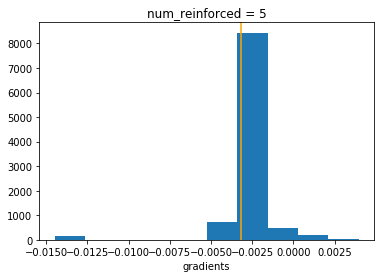

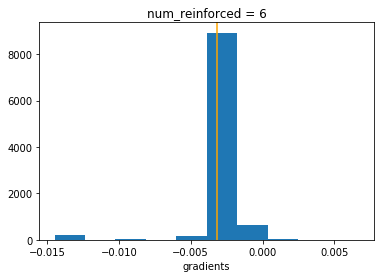

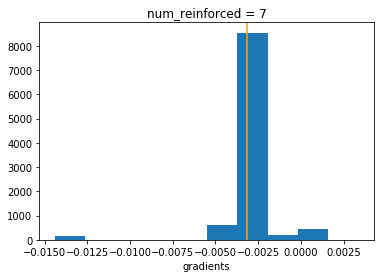

In [42]:
# Lets look at the histogram of the distribution of 
# the gradient estimates

for i in range(1, 2**d): 
    plt.figure()
    plt.hist(mixed_grads_array2[i-1, :])
    plt.axvline(x=true_grad, color = 'orange') # true gradient 
    
    plt.title('num_reinforced = {}'.format(i))
    plt.xlabel('gradients')

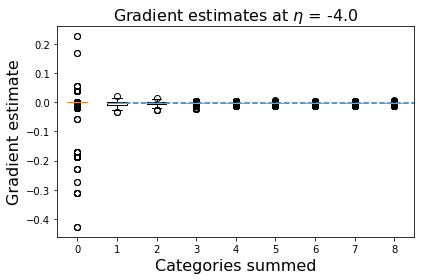

In [43]:
# summarize distribution all on the same plot
# Error bars are 3 * st. error of the distribution 

mixed_grads_means = np.mean(mixed_grads_array2.numpy(), axis = 1)
mixed_grads_stds = np.std(mixed_grads_array2.numpy(), axis = 1)

# plt.errorbar(np.arange(0, 2**d + 1), 
#              mixed_grads_means,
#              yerr= mixed_grads_stds * 3 / np.sqrt(n_samples))

plt.boxplot(mixed_grads_array2, positions = range(0, 2**d + 1))

plt.plot(np.linspace(1, 2**d + 1), true_grad.numpy() * np.ones(50), '--')

plt.ylabel('Gradient estimate', fontsize = fontsize)
plt.xlabel('Categories summed', fontsize = fontsize)
plt.title('Gradient estimates at $\eta$ = {}'.format(phi0.detach().numpy()[0]), 
          fontsize = fontsize)

plt.tight_layout()


Text(0.5,1,'standard errors at $\\eta$ = -4.0')

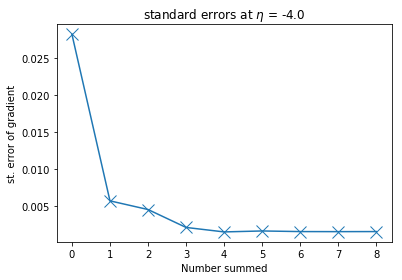

In [44]:
plt.plot(np.arange(0, 2**d + 1), mixed_grads_stds, 'x-', markersize = 12)
plt.xlabel('Number summed')
plt.ylabel('st. error of gradient')
plt.xlabel('Number summed')
plt.ylabel('st. error of gradient')
plt.title('standard errors at $\eta$ = {}'.format(phi0.detach().numpy()[0]))